In [48]:
import sys
try:
    from pyathena import connect
except:
    print("Failed to import pyathena, trying to install it")
    !{sys.executable} -m pip install PyAthena
    from pyathena import connect
    print("successfully installed")
try:
    import psycopg2
except:
    print("Failed ot import psychopg2, trying to install it")
    !{sys.executable} -m pip install psycopg2-binary
    import psycopg2
    print("Successfully installed")
import pandas as pd
import boto3
import boto3
import base64
from botocore.exceptions import ClientError
from datetime  import datetime, timedelta, date
import time

from athena_querying import *
from athena_common_queries import *

In [49]:
import creds

In [50]:
# if using jupyterlab and plotly doesn't work https://plot.ly/python/getting-started/#jupyterlab-support-python-35
install_jupyterlab_plotly_extensions_command = """
# Avoid "JavaScript heap out of memory" errors during extension installation
# (OS X/Linux)
export NODE_OPTIONS=--max-old-space-size=4096
# (Windows)
set NODE_OPTIONS=--max-old-space-size=4096

# Jupyter widgets extension
jupyter labextension install @jupyter-widgets/jupyterlab-manager@1.0 --no-build

# jupyterlab renderer support
jupyter labextension install jupyterlab-plotly@1.1.0 --no-build

# FigureWidget support
jupyter labextension install plotlywidget@1.1.0 --no-build

# JupyterLab chart editor support (optional)
jupyter labextension install jupyterlab-chart-editor@1.2 --no-build

# Build extensions (must be done to activate extensions since --no-build is used above)
jupyter lab build

# Unset NODE_OPTIONS environment variable
# (OS X/Linux)
unset NODE_OPTIONS"""



    

In [51]:
import plotly.graph_objects as go
import plotly as py

import plotly.offline as off
import plotly.graph_objs as go
import numpy as np
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import os

#off.init_notebook_mode(connected=True)

In [52]:
# plotly, which seems to have endless issues to get working reliably on sagemaker.
if True:
    fig = make_subplots(1, 1)

    fig.add_trace(
        go.Pie(values=[1,2,3], labels=["a", "b", "c"]),
    )


    fig.show()
    
    


# Settings

In [7]:
#--- Analysis Settings --
num_days_to_analyse = 10
analysis_end_time = datetime.fromordinal(date.today().toordinal()) # start of today as we only get yesterday's data.  Note it's UTC time, so do multiple days
analysis_start_time = analysis_end_time - timedelta(days=num_days_to_analyse)
country_codes_to_analyse = ["hk", "sg"] # lower case
results_output_folder = './Blog AB Results'

#--- Core Settings -- 



# --
list_out_s3_bucket = False #extremely slow.


# Getting Base Data

## Events from Athena

In [8]:
print("Connecting to Athena")
#athena_conn, athena_cursor = get_athena_conn()
athena = AthenaQuery()
athena.connect()

Connecting to Athena


In [9]:
print("Running small test query to check the athena connection")
#pd.read_sql("select * from "+athena_database+"."+athena_raw_events_table+" limit 10", athena_conn)
athena.query("select * from "+athena_database+"."+athena_raw_events_table+" limit 5")

Running small test query to check the athena connection


,type,context,user,body,sent_at,event_id,version,received_at,partition_0,partition_1,partition_2
0,page,{title=UOB Preferred Platinum Visa Card Rating...,{anonymous_id=55c4c1bb-1bc8-443c-8ec5-cf6474fd...,"{event_name=PageView, data={title=null, status...",2020-02-04T23:59:49.017Z,mse-2480753e6ed768951b7af08ceb92f745,2.5.4,2020-02-04T23:59:50.032Z,2020,2,5
1,event,"{title=smartwidget_client, page_url=https://ww...",{anonymous_id=98bcb3da-2a17-49f7-95f3-1d447ded...,"{event_name=UserView.WidgetLoad, data={title=n...",2020-02-04T23:59:48.752Z,mse-941db4b09001bfc5813bd6ae84ffaa8a,2.4.20,2020-02-04T23:59:50.218Z,2020,2,5
2,page,"{title=smartwidget_client, page_url=https://ww...",{anonymous_id=98bcb3da-2a17-49f7-95f3-1d447ded...,"{event_name=PageView, data={title=null, status...",2020-02-04T23:59:48.732Z,mse-f3965098a1738221267399b25ad50851,2.4.20,2020-02-04T23:59:50.223Z,2020,2,5
3,page,{title=Best Credit Cards Singapore 2020 Compar...,{anonymous_id=660415dc-9b6a-4cba-bb91-95e7552e...,"{event_name=PageView, data={title=null, status...",2020-02-04T23:59:49.453Z,mse-8dfffba5c3f789d980e47ec7198757f9,2.5.4,2020-02-04T23:59:49.530Z,2020,2,5
4,event,{title=Li Chun 2020 (4 Feb) - When is the Best...,{anonymous_id=131a99fe-74c0-4f90-8458-4080c614...,"{event_name=Reading, data={title=Li Chun 2020 ...",2020-02-04T23:59:50.557Z,mse-cc983d47c57d8a4b05598c918881b8f9,2.4.20,2020-02-04T23:59:51.251Z,2020,2,5


In [10]:
events = get_blog_events(country_codes_to_analyse, analysis_start_time, analysis_end_time, athena, limit =None)


Starting athena events query at 2020-02-21T06:35:31.684172
This might take some time
Getting the pageview and read events from 2020-02-11T00:00:00 to 2020-02-21T00:00:00
Query : 
    SELECT
    *
    , (CASE status
        WHEN 'Page Bottom Reached' THEN 100 
        WHEN 'Article Reading Completed' THEN 100 WHEN 'Article Body 100' THEN 100 
        WHEN 'Article Reading 75%' THEN 75 WHEN 'Article Body 75' THEN 75 
        WHEN 'Article Reading 50%' THEN 50 WHEN 'Article Body 50' THEN 50 
        WHEN 'Article Reading 25%' THEN 25 WHEN 'Article Body 25' THEN 25
        WHEN 'Article Reading Started' THEN 0 WHEN 'Article Loaded' THEN 0 
        ELSE 0 END) "article_read_depth"

    

    -- , CAST((("context"."page_url" LIKE '%utm_medium%') OR ("context"."page_url" LIKE '%gclid%')) AS boolean) "has_marketing_param"
    


    
    
    FROM
      (
          
    
    SELECT 
          CAST("from_iso8601_timestamp"("sent_at") AS timestamp) "sent_at_timestamp"
    , "sent_at"
    , subst

In [11]:
print("Got %i events"%len(events))
events.head(2)

Got 2383583 events


,sent_at_timestamp,sent_at,date,type,event_name,status,anonymous_id,amp_id,page_url,referrer,...,is_unbounce,is_embed,user_agent,device_type,browser_name,browser_major_version,browser_version,operating_system_name,operating_system_version,article_read_depth
0,2020-02-13 03:47:59.714,2020-02-13T03:47:59.714Z,2020-02-13,event,Reading,Article Body 75,147659e5-7cd3-4aec-adb0-c20cfc1e7d04,NaN,https://blog.moneysmart.sg/health-insurance/pr...,https://www.google.com.sg/,...,False,False,Mozilla/5.0 (iPhone; CPU iPhone OS 13_3_1 like...,mobile,Mobile Safari,13.0,13.0.5,iOS,13.3.1,75
1,2020-02-13 03:47:59.828,2020-02-13T03:47:59.828Z,2020-02-13,event,Reading,Article Body 50,9d3166af-db01-44ee-886b-19c951986a55,NaN,https://blog.moneysmart.sg/wedding/singapore-w...,https://www.google.com.sg/,...,False,False,Mozilla/5.0 (Linux; Android 8.1.0; CPH1803 Bui...,mobile,Opera,44.0,44.6.2246.127414,Android,8.1.0,50


In [12]:
# really this should be done in the common function, but doing here for now
# It's needed for calculating things like time between events for a given user
# It should be fairly safe as the conversion should be happening in SQL to make consistent.
if str(events.dtypes["sent_at_timestamp"])=="object": 
    print("Converting timestamp column into a datetime")
    events["sent_at_timestamp"] = pd.to_datetime(events["sent_at_timestamp"])
    events.dtypes

Converting timestamp column into a datetime


In [13]:
# Check it's using half efficient data types (more category / bool, less object)
events.dtypes

sent_at_timestamp           datetime64[ns]
sent_at                             object
date                              category
type                              category
event_name                        category
status                            category
anonymous_id                        object
amp_id                             float64
page_url                            object
referrer                          category
is_amp                                bool
is_test                               bool
is_control                            bool
slug                              category
country_code                      category
is_blog                               bool
is_unbounce                           bool
is_embed                              bool
user_agent                        category
device_type                       category
browser_name                      category
browser_major_version             category
browser_version                   category
operating_s

In [14]:
events_by_day = events.groupby([ "country_code", "date", "is_blog", "event_name"]).size().reset_index()
events_by_day.rename(columns={0:"count"}, inplace=True)
events_by_day

,country_code,date,is_blog,event_name,count
0,hk,2020-02-11,True,PageView,9789
1,hk,2020-02-11,True,Reading,18889
2,hk,2020-02-12,True,PageView,10194
3,hk,2020-02-12,True,Reading,20268
4,hk,2020-02-13,True,PageView,11010
5,hk,2020-02-13,True,Reading,21337
6,hk,2020-02-14,True,PageView,10155
7,hk,2020-02-14,True,Reading,19711
8,hk,2020-02-15,True,PageView,11770
9,hk,2020-02-15,True,Reading,22831


In [15]:
countries = events_by_day.country_code.unique()
num_countries = len(countries)

unique_events = events_by_day.event_name.unique()
num_uniqe_events = len(unique_events)

fig = py.subplots.make_subplots(rows=num_countries, cols=1)

for i, country in enumerate(countries):
    max_count = 0
    for event_name in unique_events:
        line_label = country+" "+event_name
        df = events_by_day[(events_by_day.country_code==country) & (events_by_day.event_name == event_name)]
        max_count = max(max_count, df["count"].max())
        fig.add_trace(go.Scatter(x=df["date"], y=df["count"], mode='lines', name=line_label), row=i+1, col=1)
    fig.update_yaxes(range = [0, max_count], row=i+1, col=1)
fig.update_layout(height=800)
fig.show()

In [16]:
pageview_events = events[events.event_name=="PageView"]

print("%i pageviews"%len(pageview_events))

859599 pageviews


# Pageviews Per User Per Day

In [17]:
pageviews_per_user_per_day = pageview_events.groupby(["country_code","date","is_test", "anonymous_id"]).size().reset_index(name="count")

In [18]:
pageviews_per_user_per_day.head(2)

,country_code,date,is_test,anonymous_id,count
0,hk,2020-02-11,False,00037e75-2e08-4390-98ca-a1373d684423,1
1,hk,2020-02-11,False,0007afcc-3f12-4dbf-8375-16ae0107bd25,1


In [19]:
exclude_user_with_more_than_pageviews = 10
average_pageviews_per_user_per_day = pageviews_per_user_per_day[pageviews_per_user_per_day["count"]<=exclude_user_with_more_than_pageviews]\
    .groupby(["country_code","date", "is_test"])\
    .agg({"count":["mean", "sum", "count"]}) #, "count":"sum", "count":"sum"})
average_pageviews_per_user_per_day

count              
                                     mean    sum  count
country_code date       is_test                        
hk           2020-02-11 False    1.196949   9572   7997
                        True     1.197531     97     81
             2020-02-12 False    1.193076  10029   8406
                        True     1.405405    104     74
             2020-02-13 False    1.195228  10169   8508
                        True     1.267257    716    565
             2020-02-14 False    1.179750   9077   7694
                        True     1.291310   1055    817
             2020-02-15 False    1.184868  10524   8882
                        True     1.262806   1134    898
             2020-02-16 False    1.188124  10004   8420
                        True     1.277904   1122    878
             2020-02-17 False    1.201923   9875   8216
                        True     1.236128   1047    847
             2020-02-18 False    1.199786  10089   8409
                        True     1.277005   1194    935
             2020-02-19 False    1.207596   9889   8189
                        True     1.317514   1166    885
             2020-02-20 False    1.199366   8326   6942
                        True     1.263421   1012    801
sg           2020-02-11 False    1.322245  69841  52820
                        True     1.480078   4569   3087
             2020-02-12 False    1.316346  64809  49234
                        True     1.436339   4174   2906
             2020-02-13 False    1.311540  63030  48058
                        True     1.421089   4070   2864
             2020-02-14 False    1.315966  61832  46986
                        True     1.402403   3851   2746
             2020-02-15 False    1.347551  67073  49774
                        True     1.412385   4151   2939
             2020-02-16 False    1.364282  70311  51537
                        True     1.472894   4510   3062
             2020-02-17 False    1.283860  83008  64655
                        True     1.365560   5099   3734
             2020-02-18 False    1.300162  82858  63729
                        True     1.363959   5003   3668
             2020-02-19 False    1.321656  70476  53324
                        True     1.440950   4490   3116
             2020-02-20 False    1.308177  57497  43952
                        True     1.419380   3618   2549

In [20]:
average_pageviews_per_user_per_day.rename(columns={"sum":"num_pageviews", "count":"num_users", "mean":"pageviews_per_user"}, level=1, inplace=True)

In [21]:
#average_pageviews_per_user_per_day.columns =average_pageviews_per_user_per_day.columns.get_level_values(0)
average_pageviews_per_user_per_day = average_pageviews_per_user_per_day.reset_index()
average_pageviews_per_user_per_day.rename(columns={"count":"aggregates"}, level=0, inplace=True)
#average_pageviews_per_user_per_day.rename(columns={average_pageviews_per_user_per_day.columns[3]:"pageviews_per_user", average_pageviews_per_user_per_day.columns[4]:"pageviews", average_pageviews_per_user_per_day.columns[5]:"users"},inplace=True)
average_pageviews_per_user_per_day
#TODO: sort out the column naming

country_code        date is_test         aggregates                        
                                    pageviews_per_user num_pageviews num_users
0            hk  2020-02-11   False           1.196949          9572      7997
1            hk  2020-02-11    True           1.197531            97        81
2            hk  2020-02-12   False           1.193076         10029      8406
3            hk  2020-02-12    True           1.405405           104        74
4            hk  2020-02-13   False           1.195228         10169      8508
5            hk  2020-02-13    True           1.267257           716       565
6            hk  2020-02-14   False           1.179750          9077      7694
7            hk  2020-02-14    True           1.291310          1055       817
8            hk  2020-02-15   False           1.184868         10524      8882
9            hk  2020-02-15    True           1.262806          1134       898
10           hk  2020-02-16   False           1.188124         10004      8420
11           hk  2020-02-16    True           1.277904          1122       878
12           hk  2020-02-17   False           1.201923          9875      8216
13           hk  2020-02-17    True           1.236128          1047       847
14           hk  2020-02-18   False           1.199786         10089      8409
15           hk  2020-02-18    True           1.277005          1194       935
16           hk  2020-02-19   False           1.207596          9889      8189
17           hk  2020-02-19    True           1.317514          1166       885
18           hk  2020-02-20   False           1.199366          8326      6942
19           hk  2020-02-20    True           1.263421          1012       801
20           sg  2020-02-11   False           1.322245         69841     52820
21           sg  2020-02-11    True           1.480078          4569      3087
22           sg  2020-02-12   False           1.316346         64809     49234
23           sg  2020-02-12    True           1.436339          4174      2906
24           sg  2020-02-13   False           1.311540         63030     48058
25           sg  2020-02-13    True           1.421089          4070      2864
26           sg  2020-02-14   False           1.315966         61832     46986
27           sg  2020-02-14    True           1.402403          3851      2746
28           sg  2020-02-15   False           1.347551         67073     49774
29           sg  2020-02-15    True           1.412385          4151      2939
30           sg  2020-02-16   False           1.364282         70311     51537
31           sg  2020-02-16    True           1.472894          4510      3062
32           sg  2020-02-17   False           1.283860         83008     64655
33           sg  2020-02-17    True           1.365560          5099      3734
34           sg  2020-02-18   False           1.300162         82858     63729
35           sg  2020-02-18    True           1.363959          5003      3668
36           sg  2020-02-19   False           1.321656         70476     53324
37           sg  2020-02-19    True           1.440950          4490      3116
38           sg  2020-02-20   False           1.308177         57497     43952
39           sg  2020-02-20    True           1.419380          3618      2549

In [22]:
#test_pv = average_pageviews_per_user_per_day[average_pageviews_per_user_per_day.is_test]
#control_pv = test_pv = average_pageviews_per_user_per_day[~average_pageviews_per_user_per_day.is_test]

In [23]:
pv = pd.pivot_table(average_pageviews_per_user_per_day, index=["country_code", "date"], values=["aggregates"], columns=["is_test"], fill_value="")


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/generic.py:3812: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



In [24]:
pv["aggregates", "pageviews_per_user", "v2_vs_v1"] = pv["aggregates", "pageviews_per_user", True] - pv["aggregates", "pageviews_per_user", False]


In [25]:

def color_negatives(x):
    if x>=0:
        #return "color:green"
        return ""
    return "background-color:pink"

pv.style.applymap(color_negatives, subset=["aggregates", "mean","v2_vs_v1"]) #TODO: this isn't working as intended, but hack works.

In [26]:
pv2 = pv.reset_index()

In [27]:
pv2[(pv2.country_code==country)]["aggregates", "pageviews_per_user", True].values

array([1.48007775, 1.43633861, 1.42108939, 1.4024035 , 1.41238517,
       1.47289353, 1.36555972, 1.36395856, 1.44094994, 1.41938015])

In [28]:
pv2[pv2.country_code=="sg"].date

10    2020-02-11
11    2020-02-12
12    2020-02-13
13    2020-02-14
14    2020-02-15
15    2020-02-16
16    2020-02-17
17    2020-02-18
18    2020-02-19
19    2020-02-20
Name: date, dtype: object

In [29]:
countries = pv2.country_code.unique()
num_countries = len(countries)

is_test_states = [True, False]
num_unique_states = len(is_test_states)

fig = py.subplots.make_subplots(rows=num_countries, cols=1, subplot_titles=countries)

for i, country in enumerate(countries):
    max_val = 0
    for test_state in is_test_states:
        color = "green" if test_state else "blue"
        line_label = country+" "+("v2" if test_state else "v1")
        dates = pv2[pv2.country_code==country].date
        values = pv2[(pv2.country_code==country)]["aggregates", "pageviews_per_user", test_state].values 
        max_val = max(max_val, max(values))
        fig.add_trace(go.Scatter(x=dates, y=values, mode='lines', name=line_label, line_color=color), row=i+1, col=1)
    fig.update_yaxes(range = [0, max_val+0.2], row=i+1, col=1)
    
fig.update_layout(height=800, title="Pageviews Per User Per Day")

fig.show()


In [30]:
# average_pageviews_per_user_per_day = pageviews_per_user_per_day.groupby(["country_code","date", "is_test"]).agg(average_pageviews_per_user = ("count","mean"), num_users=  ("count","sum"), num_pageviews = ("count", "sum"))

In [31]:
#average_pageviews_per_user_per_day


## Convert Raw Pageview Events Into Scroll Depth Summary

Basically re-creating:

```
CREATE OR REPLACE VIEW id_pageview_metrics AS 
SELECT
  "anonymous_id"
, "canonical_url"
, "substr"("sent_at", 1, 10) "day_str"
, "min"("sent_at_timestamp") "from_time"
, "max"("sent_at_timestamp") "to_time"
, "date_diff"('second', "min"("sent_at_timestamp"), "max"("sent_at_timestamp")) "time_on_page_seconds"
, "max"("is_test") "is_test"
, "max"("article_read_depth") "max_article_read_depth"
FROM
  id_ab_test
WHERE (NOT "is_amp")
GROUP BY 1, 2, 3   >>> should it not have is_test in the group by????
```

In [32]:
events.head()


,sent_at_timestamp,sent_at,date,type,event_name,status,anonymous_id,amp_id,page_url,referrer,...,is_unbounce,is_embed,user_agent,device_type,browser_name,browser_major_version,browser_version,operating_system_name,operating_system_version,article_read_depth
0,2020-02-13 03:47:59.714,2020-02-13T03:47:59.714Z,2020-02-13,event,Reading,Article Body 75,147659e5-7cd3-4aec-adb0-c20cfc1e7d04,NaN,https://blog.moneysmart.sg/health-insurance/pr...,https://www.google.com.sg/,...,False,False,Mozilla/5.0 (iPhone; CPU iPhone OS 13_3_1 like...,mobile,Mobile Safari,13.0,13.0.5,iOS,13.3.1,75
1,2020-02-13 03:47:59.828,2020-02-13T03:47:59.828Z,2020-02-13,event,Reading,Article Body 50,9d3166af-db01-44ee-886b-19c951986a55,NaN,https://blog.moneysmart.sg/wedding/singapore-w...,https://www.google.com.sg/,...,False,False,Mozilla/5.0 (Linux; Android 8.1.0; CPH1803 Bui...,mobile,Opera,44.0,44.6.2246.127414,Android,8.1.0,50
2,2020-02-13 03:47:59.684,2020-02-13T03:47:59.684Z,2020-02-13,event,Reading,Article Body 50,0a28adfe-a037-4e65-a544-acb6337dc3ae,NaN,https://blog.moneysmart.sg/invest/index-fund-e...,https://www.google.com.sg/,...,False,False,Mozilla/5.0 (iPhone; CPU iPhone OS 13_3_1 like...,mobile,Mobile Safari,13.0,13.0.5,iOS,13.3.1,50
3,2020-02-13 03:48:00.176,2020-02-13T03:48:00.176Z,2020-02-13,event,Reading,Article Body 100,38bd53cc-6b03-45ee-bde6-02c075988d60,NaN,https://blog.moneysmart.sg/shopping/surgical-m...,https://www.google.com.sg/,...,False,False,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,desktop,Chrome,80.0,80.0.3987.100,Windows,10,100
4,2020-02-13 03:48:00.168,2020-02-13T03:48:00.168Z,2020-02-13,page,PageView,NaN,c9bb8422-0107-4cf5-9095-1d7b836fbb59,NaN,https://blog.moneysmart.sg/invest/singapore-re...,NaN,...,False,False,Mozilla/5.0 (iPhone; CPU iPhone OS 13_3 like M...,mobile,Mobile Safari,13.0,13.0.4,iOS,13.3,0


In [33]:
cols_to_group_by = [z for z in list(events.columns) if z not in ["article_read_depth", "sent_at_timestamp", "sent_at", "event_name", "status"]]
cols_to_group_by

['date',
 'type',
 'anonymous_id',
 'amp_id',
 'page_url',
 'referrer',
 'is_amp',
 'is_test',
 'is_control',
 'slug',
 'country_code',
 'is_blog',
 'is_unbounce',
 'is_embed',
 'user_agent',
 'device_type',
 'browser_name',
 'browser_major_version',
 'browser_version',
 'operating_system_name',
 'operating_system_version']

In [34]:
events[["event_name", "status", "article_read_depth"]].head()

,event_name,status,article_read_depth
0,Reading,Article Body 75,75
1,Reading,Article Body 50,50
2,Reading,Article Body 50,50
3,Reading,Article Body 100,100
4,PageView,NaN,0


In [35]:
cols_to_group_by = ["country_code", "date","is_test", "page_url","anonymous_id", "slug"]

scroll_df = events.groupby(cols_to_group_by).agg({"article_read_depth":"max", "sent_at_timestamp":("min", "max")})

In [36]:
scroll_df.reset_index(col_level=1, inplace=True)

In [37]:
#NB: There are some massive outliars here.
scroll_df["time_on_page"] = (scroll_df["sent_at_timestamp", "max"] - scroll_df["sent_at_timestamp", "min"]).dt.total_seconds()

In [38]:
time_on_page_mins_threshold = 20
long_time_on_pages = scroll_df[scroll_df["time_on_page"]>time_on_page_mins_threshold*60]
print("found %i taking an (maybe excessively) long time on the page of %i or %.2f of total" %(len(long_time_on_pages), len(scroll_df), len(long_time_on_pages)/len(scroll_df)))

found 56523 taking an (maybe excessively) long time on the page of 745146 or 0.08 of total


In [39]:
#df.rename({5:"max_scroll_depth",6:"min_time", 7:"max_time", 8:"time_on_page"}, axis=1)
old_col_names = ["".join(z) for z in scroll_df.columns.values] #hacks for multi-level index.
new_col_names = list(old_col_names) #copy
new_col_names[6] = "max_article_read_depth"
new_col_names[7] = "min_time"
new_col_names[8] = "max_time"
new_col_names[9] ="time_on_page"
#df.rename(columns={df.columns[5]:"mouse"})
scroll_df.columns=new_col_names
scroll_df.head(5)

,country_code,date,is_test,page_url,anonymous_id,slug,max_article_read_depth,min_time,max_time,time_on_page
0,hk,2020-02-11,False,https://blog-admin.moneysmart.hk/zh-hk/uncateg...,6855fe32-f98b-4a2b-b8ee-7e3aae15c1df,/zh-hk/uncategorized/gunawan-test,0,2020-02-11 05:58:53.455,2020-02-11 06:18:19.205,1165.750
1,hk,2020-02-11,False,https://blog-admin.moneysmart.hk/zh-hk/uncateg...,6b2ba446-9c62-4625-ab66-42835422f8bd,/zh-hk/uncategorized/gunawan-test,0,2020-02-11 04:34:06.927,2020-02-11 05:14:46.831,2439.904
2,hk,2020-02-11,False,https://blog.moneysmart.hk/en,27273434-78a0-406a-bc7b-bef247e5bcae,/en,0,2020-02-11 08:42:47.090,2020-02-11 08:42:47.090,0.000
3,hk,2020-02-11,False,https://blog.moneysmart.hk/en,2c1422bf-20be-4d60-a777-fdf1919cf532,/en,0,2020-02-11 10:39:13.330,2020-02-11 10:39:13.330,0.000
4,hk,2020-02-11,False,https://blog.moneysmart.hk/en,44c16175-3044-4208-8470-dafde463abd5,/en,0,2020-02-11 03:36:25.505,2020-02-11 03:36:25.505,0.000


In [40]:
scroll_by_day = scroll_df.groupby(["country_code","is_test", "date"]).agg({"max_article_read_depth":("mean", "count")})

In [41]:
scroll_by_day.reset_index()

country_code is_test        date max_article_read_depth       
                                                      mean  count
0            hk   False  2020-02-11              52.982672   8541
1            hk   False  2020-02-12              54.171745   9025
2            hk   False  2020-02-13              53.521668   9115
3            hk   False  2020-02-14              53.736338   8143
4            hk   False  2020-02-15              53.948064   9454
5            hk   False  2020-02-16              54.207784   9019
6            hk   False  2020-02-17              54.295814   8840
7            hk   False  2020-02-18              54.920345   9039
8            hk   False  2020-02-19              53.966579   8767
9            hk   False  2020-02-20              54.569497   7468
10           hk    True  2020-02-11              47.023810     84
11           hk    True  2020-02-12              55.232558     86
12           hk    True  2020-02-13              45.251623    616
13           hk    True  2020-02-14              44.955407    897
14           hk    True  2020-02-15              43.395749    988
15           hk    True  2020-02-16              46.409990    961
16           hk    True  2020-02-17              46.995708    932
17           hk    True  2020-02-18              45.573930   1028
18           hk    True  2020-02-19              48.161389    979
19           hk    True  2020-02-20              44.456887    893
20           sg   False  2020-02-11              48.435191  61589
21           sg   False  2020-02-12              47.310294  57655
22           sg   False  2020-02-13              47.583804  55904
23           sg   False  2020-02-14              47.248867  54523
24           sg   False  2020-02-15              49.026244  58947
25           sg   False  2020-02-16              50.108954  62182
26           sg   False  2020-02-17              52.674325  74645
27           sg   False  2020-02-18              53.254344  74462
28           sg   False  2020-02-19              51.024584  62806
29           sg   False  2020-02-20              48.621138  51111
30           sg    True  2020-02-11              49.845027   3549
31           sg    True  2020-02-12              47.064339   3466
32           sg    True  2020-02-13              47.262144   3479
33           sg    True  2020-02-14              46.904025   3230
34           sg    True  2020-02-15              48.281340   3462
35           sg    True  2020-02-16              49.220430   3720
36           sg    True  2020-02-17              52.721433   4437
37           sg    True  2020-02-18              52.455876   4306
38           sg    True  2020-02-19              48.970897   3814
39           sg    True  2020-02-20              47.293901   2984

In [42]:
scroll_by_day  = pd.pivot_table(scroll_by_day, index=["country_code", "date"], values=["max_article_read_depth"], columns=["is_test"], fill_value="")

In [43]:
scroll_by_day.rename(columns={"mean":"av_max_article_read_depth"}, inplace=True)


In [44]:
#scroll_by_day.columns = scroll_by_day.columns.droplevel(level=1)

In [45]:
scroll_by_day

max_article_read_depth        \
                                         count         
is_test                                  False True    
country_code date                                      
hk           2020-02-11                   8541    84   
             2020-02-12                   9025    86   
             2020-02-13                   9115   616   
             2020-02-14                   8143   897   
             2020-02-15                   9454   988   
             2020-02-16                   9019   961   
             2020-02-17                   8840   932   
             2020-02-18                   9039  1028   
             2020-02-19                   8767   979   
             2020-02-20                   7468   893   
sg           2020-02-11                  61589  3549   
             2020-02-12                  57655  3466   
             2020-02-13                  55904  3479   
             2020-02-14                  54523  3230   
             2020-02-15                  58947  3462   
             2020-02-16                  62182  3720   
             2020-02-17                  74645  4437   
             2020-02-18                  74462  4306   
             2020-02-19                  62806  3814   
             2020-02-20                  51111  2984   

                                                              
                        av_max_article_read_depth             
is_test                                     False      True   
country_code date                                             
hk           2020-02-11                 52.982672  47.023810  
             2020-02-12                 54.171745  55.232558  
             2020-02-13                 53.521668  45.251623  
             2020-02-14                 53.736338  44.955407  
             2020-02-15                 53.948064  43.395749  
             2020-02-16                 54.207784  46.409990  
             2020-02-17                 54.295814  46.995708  
             2020-02-18                 54.920345  45.573930  
             2020-02-19                 53.966579  48.161389  
             2020-02-20                 54.569497  44.456887  
sg           2020-02-11                 48.435191  49.845027  
             2020-02-12                 47.310294  47.064339  
             2020-02-13                 47.583804  47.262144  
             2020-02-14                 47.248867  46.904025  
             2020-02-15                 49.026244  48.281340  
             2020-02-16                 50.108954  49.220430  
             2020-02-17                 52.674325  52.721433  
             2020-02-18                 53.254344  52.455876  
             2020-02-19                 51.024584  48.970897  
             2020-02-20                 48.621138  47.293901

In [46]:
scroll_by_day["max_article_read_depth","av_max_article_read_depth", "v2_vs_v1_av_read_depth"] = \
    scroll_by_day["max_article_read_depth","av_max_article_read_depth", True]-scroll_by_day["max_article_read_depth","av_max_article_read_depth", False] 

In [47]:
def color_negatives(x):
    if x>=0:
        #return "color:green"
        return ""
    return "background-color:pink"

scroll_by_day.style.applymap(color_negatives) 

# Queries to Add
```

select * from id_pageview_metrics where time_on_page_seconds <5 and max_article_read_depth = 100 limit 100
```
---
```
select * from id_engagement_summary order by day_str, is_test 

```

# Data Cleaning

* Remove what looks like bots / any really heavy users (not sure if most bots will trigger analytics events)


In [47]:
non_amp_events = events[events.is_amp==False]

# Sense Checks

## Overall AB Split

Theories about why the AB split won't match what is "set" on the AB splitter:

* Repeat users will almost always be in the control set, and we have built up a good backlog over a couple of months (40% of our users are returning from google analytics, but that is over full lifetime of the cookie https://analytics.google.com/analytics/web/?authuser=2#/report/visitors-type/a117250120w173910722p173182279/ )
* Potenially it's related to coming from AMP (don't think so)
* Potentially it's based on origin of the traffic (e.g. certain query params, but this has been turned off).

In [48]:
ab_split_summary = non_amp_events.groupby("is_test").count()["sent_at"]
ab_split_summary_pretty = [[("Test (v2)" if z[0] else "Control (v1)"), z[1]] for z in ab_split_summary.iteritems()]


import plotly.graph_objects as go
fig = make_subplots(1, 1)

fig.add_trace(
    go.Pie(values=[z[1] for z in ab_split_summary_pretty], labels=[z[0] for z in ab_split_summary_pretty]),
)

                
fig.show()

## Type of Event

In [49]:
len(events)

1600945

In [50]:
event_name_counts = events.groupby(events.event_name).size()
event_name_counts


event_name
PageView     583563
Reading     1017382
dtype: int64

([<matplotlib.patches.Wedge at 0x7f49a4248198>,
 [Text(0.4542035828902738, 1.0018478453785478, 'PageView'),
  Text(-0.4542036766900372, -1.0018478028529345, 'Reading')])

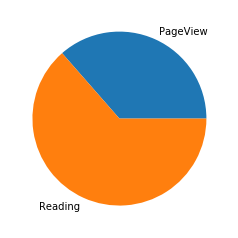

In [51]:
plt.pie(event_name_counts, labels=event_name_counts.keys())

In [52]:
# Doing this sense check on the event fields, not the computed depth
expected_statuses = ["Article Body {}".format(i) for i in [0, 25, 50, 75, 100]]
expected_statuses_set = set(expected_statuses)
reading_status_counts = events[events.event_name=="Reading"].groupby([events.status, events.is_test]).count()['sent_at'] #[["event_name", "is_test" ], :]
reading_status_counts.sort_index()
reading_status_counts = [[z[0][0], z[0][1], z[1]] for z in reading_status_counts.iteritems()]
test_reading_status_counts = [z for z in reading_status_counts if z[1]==True]
control_reading_status_counts = [z for z in reading_status_counts if z[1]==True]

for name, reading_statuses in [["Test", test_reading_status_counts], ["Control", control_reading_status_counts]]:
    statuses_set = set([z[0] for z in reading_statuses])
    missing_statuses = list(expected_statuses_set - statuses_set)
    extra_statuses = list(statuses_set - expected_statuses_set)
    
    if len(missing_statuses)>0:
        print("ERROR: Missing expected statuses for Reading event in "+name+": " + ", ".join(missing_statuses))
        
    if len(extra_statuses)>0:
        print("ERROR: Unexpected statuses for Reading event in "+name+": " + ", ".join(extra_statuses))
                        
# Going to look at scroll depth comparison lower down, so don't need to worry about it just now.


ValueError: Length of grouper (1600945) and axis (1017382) must be same length

In [ ]:
expected_statuses

## Pageviews Grouped

* By category
* By device
* By query params (limited to the top n, and grouping glcid and fbclid)

... and for each one give the v2 percentage (which might need another chart)

## Distribution Over Time

In [ ]:
# Group by hour and plot with time axis
events.groupby([events.sent_at_timestamp.hour, events.is_test]).count()

# Scroll Depth Distributions

By split:
* How far down the page does a user scroll on average (table and plot)
* Time to reach a point down the page (charts) 


# Pageview Per Session

* Where they click (future)
* 

# Exploring by Browser / Device

We've seen issues on Babe, UCBrowser etc.  Need to check if there are issues from those platforms.

The issues we saw likely resulted in scroll depth issues.  I'm also not sure what analytics we're going to get from those platform, so just generally need to poke it.

## Hacky Events By Device Type

In [ ]:
events.head()
events[events.event_name=="PageView"].head()

In [ ]:
# Get the events for a given day by device type, across all URLs


""", context.device.type as device_type
        , context.browser.name as browser_name
        , context.browser.major as browser_major_version
        , context.browser.version as browser_version
        
        , context.operating_system.name as operating_system_name
        , context.operating_system.version as operating_system_version
        , context.user_agent as user_agent"""

#cols_to_group_by = ["event_name", "status",  "device_type", "browser_name", "browser_version"]
cols_to_group_by = ["event_name", "status",  "device_type", "browser_name"]
# cols_to_group_by = ["event_name", "status",  "device_type", "browser_name", "user_agent"]
#cols_to_group_by  = ["event_name", "status",  "device_type", ]
# combined_raw_df  = events.groupby(cols_to_group_by+["is_test",]).size()

combined_raw_df = pd.DataFrame({"count":events.fillna(0).groupby(cols_to_group_by+["is_test",]).size()}).reset_index()  #fillna(-1) is to stop it removing Nulls 

# combined_raw_df[combined_raw_df.event_name=="PageView"]


In [ ]:
# combined_raw_df[combined_raw_df.is_test==True]

In [ ]:


# join across both sides of the AB test
test_df =combined_raw_df[combined_raw_df.is_test==True]
test_df = test_df.rename(columns={"count":"test_count"}) #in_place = True
control_df = combined_raw_df[combined_raw_df.is_test==False]
control_df = control_df.rename(columns={"count":"control_count"})

print(test_df.head(20))

#print(control_df.head())



#print(test_df.keys)
test_df.reset_index()
#print(20*"-")
#print(test_df.keys())
#print(test_df.columns)
test_df
control_df.reset_index()
test_df = test_df.set_index(cols_to_group_by)
control_df = control_df.set_index(cols_to_group_by)

combined_df = test_df.join(control_df, rsuffix="_").reset_index()
#combined_df.fillna(0) #get rid of NaN

In [ ]:
combined_df["test_fraction"] = combined_df.apply (lambda row: row.test_count/(row.control_count + row.test_count), axis=1)

In [ ]:
combined_df.head()

In [ ]:
#combined_df[combined_df['control_count']>1000][combined_df['browser_name']=="Facebook"].sort_values(["browser_name", "browser_version", "status"]) #.to_csv("results.csv")
#combined_df[combined_df['control_count']>1000][combined_df['browser_name']=="UCBrowser"][(combined_df['event_name']=="PageView")  | (combined_df['status']=="Article Body 100")].sort_values(["device_type","browser_name","status"]) #.to_csv("results.csv")
# "test_fraction", 
#.sort_values(["control_count"])#

combined_df[combined_df['control_count']>1000][combined_df['browser_name']=="Facebook"].sort_values(["status", "browser_name"]) #.to_csv("results.csv")

# df = combined_df[combined_df['control_count']>100].sort_values(["user_agent", "event_name","status"])
# df.to_csv("test_fraction_by_user_agent.csv")

# combined_df[combined_df['control_count']>1000].sort_values(["browser_name", "browser_version", "status"]) #.to_csv("results.csv")

#combined_df[combined_df['control_count']>100][combined_df['test_count']>50].sort_values(["test_fraction"])


In [ ]:
208638.0 / len(events[events.event_name=="PageView"])

In [ ]:
len(events[events.is_amp==True][events.event_name=="PageView"])

## Hacky Check That No Pages Have Issues

In [ ]:
events.head()


In [ ]:
cols_to_group_by = ["canonical_url","type", "event_name", "status", "is_test", "device_type"]
# events_by_url = events.groupby(cols_to_group_by)
# events_by_url.head()

combined_raw_df = pd.DataFrame({"count":events.fillna(0).groupby(cols_to_group_by).size()}).reset_index()
combined_raw_df

In [ ]:

# join across both sides of the AB test
test_df =combined_raw_df[combined_raw_df.is_test==True]
test_df = test_df.rename(columns={"count":"test_count"}) #in_place = True
control_df = combined_raw_df[combined_raw_df.is_test==False]
control_df = control_df.rename(columns={"count":"control_count"})

print(test_df.head(20))

#print(control_df.head())



#print(test_df.keys)
test_df.reset_index()
#print(20*"-")
#print(test_df.keys())
#print(test_df.columns)
test_df
control_df.reset_index()
test_df = test_df.set_index(cols_to_group_by)
control_df = control_df.set_index(cols_to_group_by)

combined_df = test_df.join(control_df, rsuffix="_").reset_index()
#combined_df.fillna(0) #get rid of NaN

In [ ]:
combined_df["test_fraction"] = combined_df.apply (lambda row: row.test_count/(row.control_count + row.test_count), axis=1)

In [ ]:
events[events.canonical_url.str.endswith("https://www.moneysmart.id/")].groupby(["canonical_url"]).size()

In [ ]:
events[events.canonical_url == "https://www.moneysmart.id/"].groupby(["canonical_url", "is_test"]).size()

In [ ]:
combined_df[combined_df.canonical_url=="https://www.moneysmart.id/"]

In [ ]:
# combined_df[combined_df.test_fraction<0.05][(combined_df['event_name']=="PageView")  | (combined_df['status']=="Article Body 100")].sort_values(combined_df.test_fraction) #.to_csv("results.csv")
# combined_df.sort_values(combined_df.canonical_url).head()
combined_df.sort_values("canonical_url")

>> we're missing some events here e.g. if you look at homepage.  Likely need to fill with zeros or soemthign.

# Search Console.

* Position, clicks, impressions over time, with country filter set to ID
* Track top organic urls and see if there's a different trend

In [ ]:
0.0584*24*30

# Digging Into What Makes Up a Split

* By URL any significant  discrepancy?
* Is it distorted by bots?

## Pages Performing Worse in v2 Than v1

Background to this is that we are seeing a drop off at the top of the page, and that might be due to specific pages, so we want to know if pages are performing poorly:

* Pageviews ratio
* Average scroll depth

# Query Params

In [ ]:
non_amp_pageview_query_params[0]

In [ ]:
pqdf = pd.DataFrame()
pqdf["query_params"]=non_amp_pageview_query_params
pqdf["sent_at_timestamp"] = pageview_events[pageview_events.is_amp==False]["sent_at_timestamp"]

In [ ]:
pqdf.head()

In [ ]:
pqdf.dtypes

In [ ]:
query_params_by_date = pqdf.groupby([pqdf.sent_at_timestamp.dt.floor('d'), pqdf.query_params]).count()

In [ ]:
query_params_by_date #.sort_values(query_params_by_date.sent_at_timestamp)